In [1]:
# Run some setup code for this notebook.

import random
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import numpy as np

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image

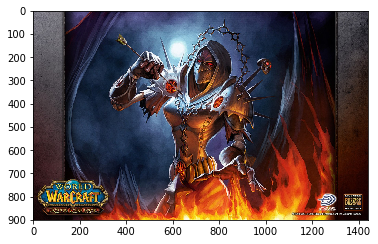

In [3]:
img_data = Image.open('5132.jpg')
img_np = np.array(img_data)
plt.imshow(img_np)

# CIFAR-10 数据加载与预处理

In [4]:
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
# 将数据划分成训练集、验证集和测试集。另外，我们将创建一个小的开发集作为测试集的子集
# 我们可以使用开发集进行开发以使我们的代码运行得更快

num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500
# 验证集： X_train[num_training, num_training + num_valid)
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# 训练集： X_train[0, num_training)
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# 开发集：从训练集中随机抽取 num_dev 个 
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# 测试集： X_test[0, num_test]
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]
X_train = torch.from_numpy(X_train).reshape(X_train.shape[0], -1)
X_val = torch.from_numpy(X_val).reshape(X_val.shape[0], -1)
X_test = torch.from_numpy(X_test).reshape(X_test.shape[0], -1)
X_dev = torch.from_numpy(X_dev).reshape(X_dev.shape[0], -1)
y_train = torch.from_numpy(y_train).reshape(y_train.shape[0], -1)
y_val = torch.from_numpy(y_val).reshape(y_val.shape[0], -1)
y_dev = torch.from_numpy(y_dev).reshape(y_dev.shape[0], -1)

In [5]:
# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.size())
print('Validation data shape: ', X_val.size())
print('Test data shape: ', X_test.size())
print('dev data shape: ', X_dev.size())

Training data shape:  torch.Size([49000, 3072])
Validation data shape:  torch.Size([1000, 3072])
Test data shape:  torch.Size([1000, 3072])
dev data shape:  torch.Size([500, 3072])


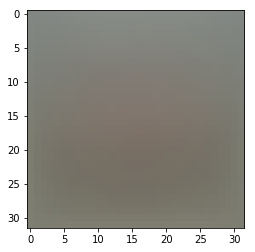

In [6]:
# Preprocessing: subtract the mean image 
# first: compute the image mean based on the training data
# 预处理：抽取平均图像
# 1. 计算训练数据图像的平均值
mean_image = torch.mean(X_train, dim=0, keepdim=False)
# plt.imshow的data是(32, 32, 3)，而torch的数据是(3, 32, 32)，需要转换成plt格式
mean_image_plt = mean_image.reshape(32, 32, 3).numpy()

plt.figure(figsize=(4,4))
plt.imshow(mean_image_plt.astype('uint8'))
plt.show()

In [7]:
# second: subtract the mean image from train and test data
# 2. 训练集和测试集都减去训练集均值
print("X_train size:", X_train.size())  # torch.Size([49000, 3072])
print("mean_image size:", mean_image.size())  #  torch.Size([3072])
# 张量 - 向量，匹配最后1维  正确：维度(3,5,1) - 维度(1,)  错误：(3,5,1) - (5,)

X_train -= mean_image 
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

X_train size: torch.Size([49000, 3072])
mean_image size: torch.Size([3072])


In [15]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# 3. 加上偏置维度，所以我们的SVM只有一个优化权重矩阵：W

X_train = torch.cat((X_train, torch.ones(X_train.size(0), 1).double()), dim=1)
X_val = torch.cat((X_val, torch.ones(X_val.size(0), 1).double()), dim=1)
X_test = torch.cat((X_test, torch.ones(X_test.size(0), 1).double()), dim=1)
X_dev = torch.cat((X_dev, torch.ones(X_dev.size(0), 1).double()), dim=1)

print(X_train.size(), X_val.size(), X_test.size(), X_dev.size())

torch.Size([49000, 3074]) torch.Size([1000, 3073]) torch.Size([1000, 3073]) torch.Size([500, 3073])


# SVM 分类器

In [25]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_vectorized_torch
import time

# generate a random SVM weight matrix of small numbers
# 创造一个随机SVM权重矩阵
W = torch.randn(3073, 10).double() * 0.0001

loss, grad = svm_loss_vectorized_torch(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.338992


In [26]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
# 计算损失和它在W处的梯度
loss, grad = svm_loss_vectorized_torch(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
# 计算几个随机点的数值梯度，然后与你的解析梯度比较

from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_vectorized_torch(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -7.087168 analytic: -14.174336, relative error: 3.333333e-01
numerical: 4.689351 analytic: 9.378701, relative error: 3.333333e-01
numerical: -21.937745 analytic: -43.875490, relative error: 3.333333e-01
numerical: 8.617805 analytic: 17.235611, relative error: 3.333333e-01
numerical: 12.387918 analytic: 24.775837, relative error: 3.333333e-01
numerical: 9.999943 analytic: 19.999886, relative error: 3.333333e-01
numerical: -12.089052 analytic: -24.178103, relative error: 3.333333e-01
numerical: -10.285236 analytic: -20.570472, relative error: 3.333333e-01
numerical: -4.803812 analytic: -9.607624, relative error: 3.333333e-01
numerical: -1.823234 analytic: -3.646468, relative error: 3.333333e-01
